In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from tqdm import trange
import matplotlib.pyplot as plt

### 定义模型

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    
    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X)))
        return torch.cat((p1, p2, p3, p4), dim=1)

In [3]:
# 第一块
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, padding=1, stride=2))

In [4]:
# 第二块
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, padding=1, stride=2))

In [5]:
# 第三块
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, padding=1, stride=2))

In [6]:
# 第四块
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, padding=1, stride=2))

In [7]:
# 第五块
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)),
                   nn.Flatten())

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [9]:
X = torch.rand(size=(1, 1, 96, 96), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 48, 48])
Sequential output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 480, 12, 12])
Sequential output shape:	 torch.Size([1, 832, 6, 6])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### 数据导入

In [10]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

### 模型准确率评估

In [11]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device='None'):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    
    num_accurate, num_sum = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            num_accurate += accuracy(net(X), y)
            num_sum += y.numel()
    return num_accurate / num_sum

### 模型训练

In [12]:
def train(net, train_iter, test_iter, num_epochs, lr, device='cuda'):
    # 参数初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    # gpu 训练
    print('training on', device)
    net.to(device)
    # 定义优化器与损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    # 开始迭代
    train_list, test_list, loss_list = [], [], []
    for epoch in trange(num_epochs, desc="Training", unit="epoch"):
        net.train()
        l_sum, train_sum, num_sum = 0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            optimizer.zero_grad()
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # 计算过程
            with torch.no_grad():
                l_sum += l * X.shape[0]
                train_sum += accuracy(y_hat, y)
                num_sum += X.shape[0]
        test_ac = evaluate_accuracy_gpu(net, test_iter, device)
        train_list.append(train_sum / num_sum)
        test_list.append(test_ac)
        loss_list.append(l_sum / num_sum)
        
    return train_list, test_list, loss_list

In [13]:
num_epochs, lr = 10, 0.1
train_list, test_list, loss_list = train(net, train_iter, test_iter, num_epochs, lr, device='cuda')

training on cuda


Training: 100%|██████████| 10/10 [10:45<00:00, 64.55s/epoch]


### 训练结果

In [14]:
loss_list = [l.cpu() for l in loss_list]

最终 train_ac: 0.894, test_ac: 0.882


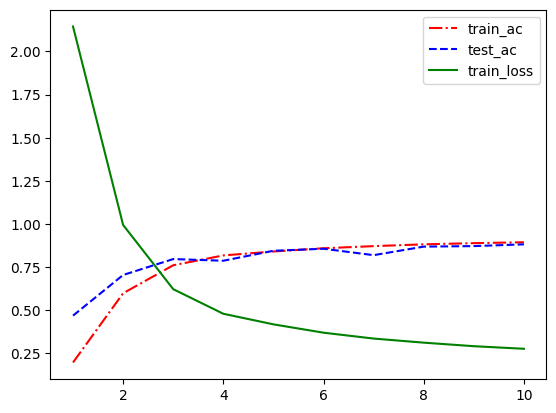

In [15]:
print(f'最终 train_ac: {train_list[-1]:.3f}, test_ac: {test_list[-1]:.3f}')
plt.plot(list(range(1, num_epochs+1)), train_list, color='red', linestyle='-.', label='train_ac')
plt.plot(list(range(1, num_epochs+1)), test_list, color='blue', linestyle='--', label='test_ac')
plt.plot(list(range(1, num_epochs+1)), loss_list, color='green', label='train_loss')
plt.legend()
plt.show()